In [15]:
import pandas as pd
import sklearn
import numpy as np
import util
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pydotplus
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dtreeviz.trees import dtreeviz
import lightgbm as lgb

In [17]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm 
import matplotlib.pylab as plt 
from dmba import regressionSummary, exhaustive_search 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.metrics import r2_score
from dmba import backward_elimination, forward_selection

In [18]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 81)

In [33]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)
#feature = pd.read_csv('Data/Created Datasets/KSI_Feature_Collapse.csv', index_acol = 0)
#count = pd.read_csv('Data/Created Datasets/KSI_Collapse_Count_truncate3.csv')

In [19]:
# dataset without hazardous dataset - this dataset is bigger

ultimate_df = pd.read_csv('Data/Created Datasets/Impediments_Feature_Count.csv', index_col = 0)

In [6]:
# only downtown

ultimate_df = ultimate_df[(ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700)]

In [20]:
# not downtown

ultimate_df = ultimate_df[~((ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700))]

In [21]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [8]:
print(ultimate_df['DRIVCOND'].unique())
print(ultimate_df['DRIVACT'].unique())
print(ultimate_df['LIGHT'].unique())
print(ultimate_df['TRAFFCTL'].unique())
print(ultimate_df['VEHTYPE'].unique())
print(ultimate_df['INVAGE'].unique())
#print(ultimate_df['MANOEUVER'].unique())

['Normal' 'Inattentive' 'Ability Impaired (Drugs/Alcohol)' 'Unknown'
 '<Null>' 'Medical or Physical Disability' 'Other' 'Fatigue']
['Lost control' 'Speeding' 'Other' 'Improper Turn'
 'Failed to Yield Right of Way' 'Improper Lane Change'
 'Disobeyed Traffic Control' 'Speed too Fast For Condition'
 'Following too Close' '<Null>' 'Wrong Way on One Way Road'
 'Improper Passing' 'Speed too Slow']
['Daylight' 'Artificial' 'Dark' 'Dawn' 'Dusk']
['No Control' 'Traffic Signal' 'Stop/Yield Sign' 'Pedestrian Crossover'
 'Streetcar (Stop for)' 'Controller present' '<Null>']
['Small-size Vehicle' 'Two Wheeler' 'Medium-size Vehicle'
 'Large-size Vehicle' 'Other']
['Adult' 'Young Adult' 'Senior' 'Super Senior' 'Children']


In [22]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [23]:
ultimate_df['TIME'] = round(ultimate_df['TIME']/100,3)
#ultimate_df.head()

In [9]:
ultimate_df.columns

Index(['IncidentsTotal', 'SeverityScore', 'PercentOfVehicles',
       'AvgAcceleration', 'LATITUDE', 'LONGITUDE', 'COUNT', 'INVAGE',
       'RDSFCOND', 'VISIBILITY', 'LIGHT', 'TRAFFCTL', 'DRIVACT', 'DRIVCOND',
       'VEHTYPE', 'TIME'],
      dtype='object')

In [24]:
# for full
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther', 'TIME')]]

X['PercentOfVehicles'] = (X['PercentOfVehicles'] > X['PercentOfVehicles'].mean()).astype('int')
X['AvgAcceleration'] = (X['AvgAcceleration'] > X['AvgAcceleration'].mean()).astype('int')
# for full
#X['SeverityScore'] = (X['SeverityScore'] > X['SeverityScore'].mean()).astype('int')
#X['IncidentsTotal'] = (X['IncidentsTotal'] > X['IncidentsTotal'].mean()).astype('int')

# dont do this - gives weird results
#X['TIME'] = X['TIME'].apply(util.daygroup)

X = pd.get_dummies(X, drop_first = True)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
X.shape

(706, 51)

In [10]:
# ONLY RUN THESE FOR LIGHTGBM

X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther', 'TIME')]]

X['PercentOfVehicles'] = (X['PercentOfVehicles'] > X['PercentOfVehicles'].mean()).astype('int')
X['AvgAcceleration'] = (X['AvgAcceleration'] > X['AvgAcceleration'].mean()).astype('int')
X['SeverityScore'] = (X['SeverityScore'] > X['SeverityScore'].mean()).astype('int')
X['IncidentsTotal'] = (X['IncidentsTotal'] > X['IncidentsTotal'].mean()).astype('int')
#X = pd.get_dummies(X)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

# ABSOLUTELY IMPORTANT STEP

for c in X.columns:
     col_type = X[c].dtype
     if col_type == 'object' or col_type.name == 'category':
         X[c] = X[c].astype('category')
         X[c] = X[c].cat.codes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [25]:
Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [11]:
# Does the model perform better than the null model?
# Our created models must be able to beat this:
# I'm comparing valid_Y to the mean of COUNT. 

regressionSummary(valid_Y, np.repeat(Y.mean(), valid_Y.shape))


Regression statistics

                      Mean Error (ME) : 0.1343
       Root Mean Squared Error (RMSE) : 2.1135
            Mean Absolute Error (MAE) : 1.6914
          Mean Percentage Error (MPE) : -54.8264
Mean Absolute Percentage Error (MAPE) : 86.1793


In [39]:
param_grid = { 
 'max_depth': [3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
 'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001], 
 'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005] 
} 

In [40]:
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state = 1), param_grid, cv = 5, n_jobs = -1)
gridSearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001],
                         'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005]})

In [41]:
gridSearch.best_estimator_

DecisionTreeRegressor(max_depth=7, min_impurity_decrease=0.05,
                      min_samples_split=0.01, random_state=1)

In [44]:
# this creates a unique looking dctree with distributions of variables and the split shown

viz = dtreeviz(gridSearch.best_estimator_, valid_X, valid_Y,
               target_name="COUNT",
               feature_names= valid_X.columns,
               title="Decision Tree For Fully Merged Dataset",
               )

viz.save("decision_tree_wine.svg")

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
Mean of empty slice.
invalid value encountered in double_scalars


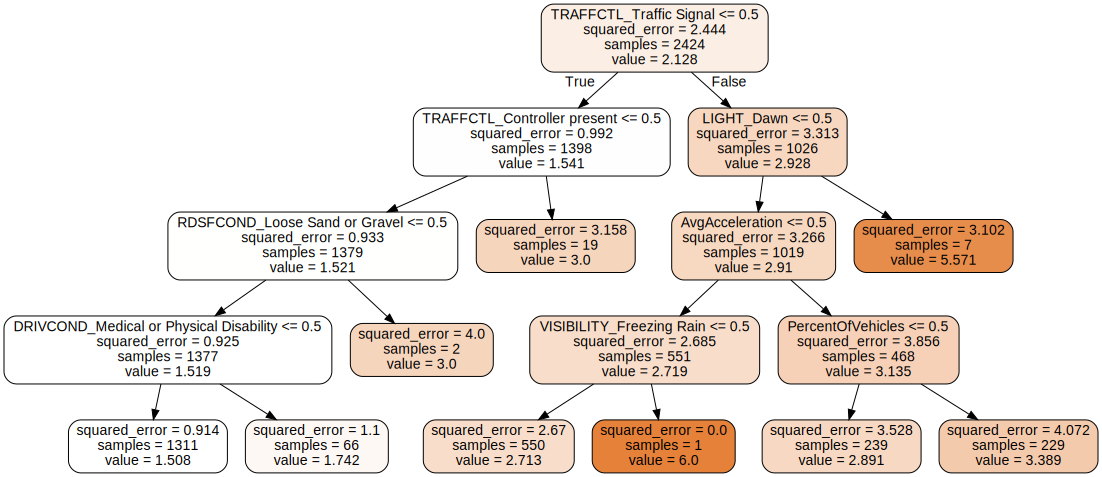

In [16]:
# this creates a LARGE dctree visual - DON'T RUN otherwise

import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(gridSearch.best_estimator_, 
                           feature_names=valid_X.columns, 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph

In [ ]:
plotDecisionTree(gridSearch.best_estimator_, train_X.columns)

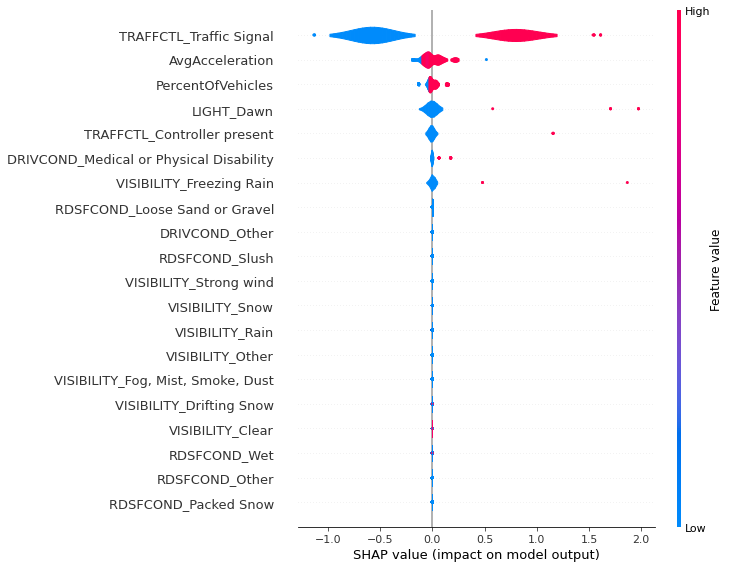

In [17]:
explainer = shap.TreeExplainer(gridSearch.best_estimator_)
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X, plot_type = 'violin')

In [18]:
print(regressionSummary(train_Y, gridSearch.best_estimator_.predict(train_X)))
regressionSummary(valid_Y, gridSearch.best_estimator_.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1.3782
            Mean Absolute Error (MAE) : 1.0208
          Mean Percentage Error (MPE) : -33.3432
Mean Absolute Percentage Error (MAPE) : 57.8368
None

Regression statistics

                      Mean Error (ME) : -0.0771
       Root Mean Squared Error (RMSE) : 1.3533
            Mean Absolute Error (MAE) : 1.0083
          Mean Percentage Error (MPE) : -35.7004
Mean Absolute Percentage Error (MAPE) : 58.6345


In [12]:
fit_params={
            "eval_metric" : 'l2', 
            "eval_set" : [(valid_X, valid_Y), (train_X, train_Y)],
            'eval_names': ['valid','train'],
            'feature_name': 'auto', 
            'categorical_feature': X.select_dtypes("int8").columns.tolist()
           }
           
lgbreg = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='l2', 
                         n_jobs= -1, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1,
                         )


lgbreg.fit(train_X, train_Y, **fit_params)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is ['DRIVACT', 'DRIVCOND', 'INVAGE', 'LIGHT', 'RDSFCOND', 'TRAFFCTL', 'VEHTYPE', 'VISIBILITY']
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[1]	train's l2: 3.74626	valid's l2: 4.2946
[2]	train's l2: 3.62967	valid's l2: 4.14418
[3]	train's l2: 3.54006	valid's l2: 4.02401
[4]	train's l2: 3.4742	valid's l2: 3.94255
[5]	train's l2: 3.4106	valid's l2: 3.85735
[6]	train's l2: 3.3591	valid's l2: 3.78699
[7]	train's l2: 3.30609	valid's l2: 3.72563
[8]	train's l2: 3.26152	valid's l2: 3.67465
[9]	train's l2: 3.23183	valid's l2: 3.62956
[10]	train's l2: 3.20164	valid's l2: 3.58937
[11]	train's l2: 3.17657	valid's l2: 3.55997
[12]	train's l2: 3.1577	valid's l2: 3.53342
[13]	train's l2: 3.14018	valid's l2: 3.51497
[14]	train's l2: 3.11834	valid's l2: 3.50316
[15]	train's l2: 3.10088	valid's l2: 3.49967
[16]	train's l2: 3.08314	valid's l2: 3.48325
[17]	train's l2: 3.06495	valid's l2: 3.47526
[18]	train's l2: 3.0529	valid's l2: 3.46151
[19]	train's l2: 3.03876	valid's l2: 3.45297
[20]	train's l2: 3.02947	valid's l2: 3.44144
[21]	train's l2: 3.01476	valid's l2: 3.44541
[22]	train's l2: 3.00341	valid's l2: 3.43653
[23]	train's l2: 2.99042	

LGBMRegressor(colsample_bytree=0.9, metric='l2', n_estimators=1000,
              num_leaves=15, random_state=314, silent=True, subsample=0.9)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

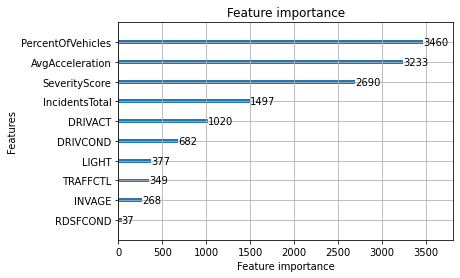

In [13]:
lgb.plot_importance(lgbreg)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

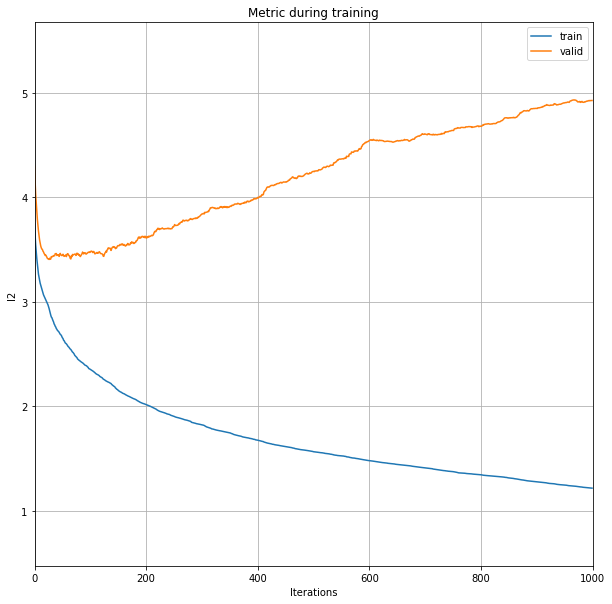

In [14]:
lgb.plot_metric(lgbreg, figsize = (10,10))

<AxesSubplot:>

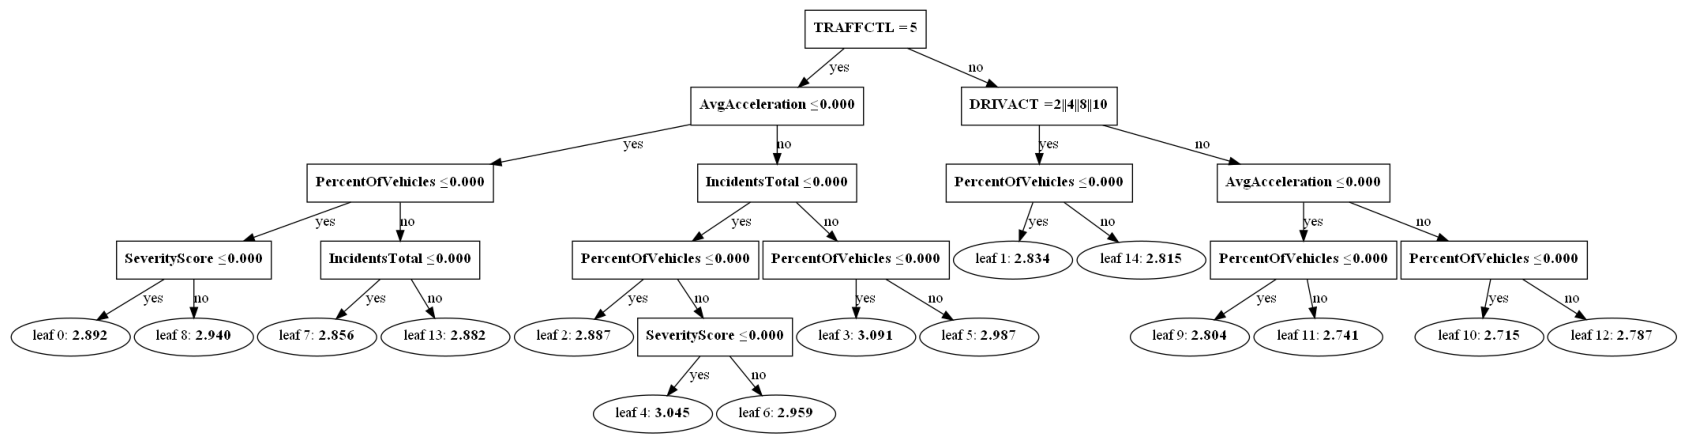

In [17]:
lgb.plot_tree(lgbreg, orientation = 'vertical', figsize=(30,30))

In [16]:
print(regressionSummary(train_Y, lgbreg.predict(train_X)))
regressionSummary(valid_Y, lgbreg.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1.1022
            Mean Absolute Error (MAE) : 0.8093
          Mean Percentage Error (MPE) : -22.2544
Mean Absolute Percentage Error (MAPE) : 41.0936
None

Regression statistics

                      Mean Error (ME) : 0.1020
       Root Mean Squared Error (RMSE) : 2.2191
            Mean Absolute Error (MAE) : 1.6604
          Mean Percentage Error (MPE) : -40.4978
Mean Absolute Percentage Error (MAPE) : 81.8649


In [ ]:
explainer = shap.Explainer(lgbreg)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)

In [26]:
rf = RandomForestRegressor(n_estimators = 2000, random_state = 1) 
rf.fit(train_X, train_Y)

RandomForestRegressor(n_estimators=2000, random_state=1)

In [27]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

Text(0.5, 1.0, 'Visualizing Important Features')

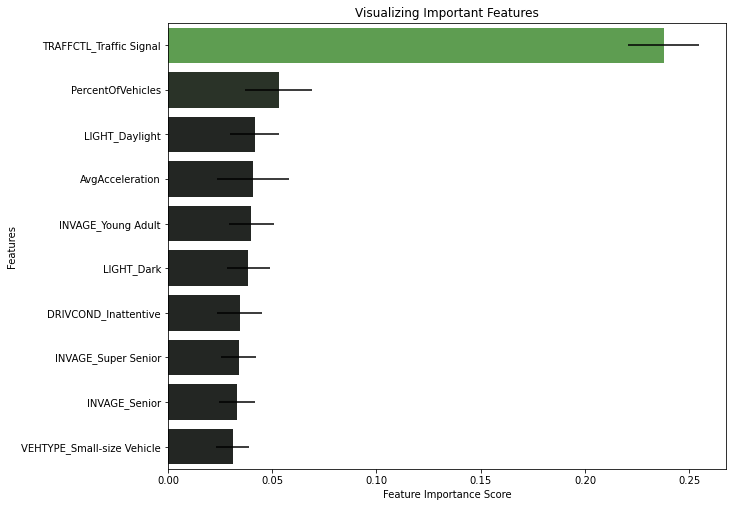

In [29]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0) 
tf = pd.DataFrame({'feature': train_X.columns, 'importance': rf.feature_importances_, 'std': std}) 
tf = tf.sort_values('importance', ascending = False)
plt.figure(figsize = (10,8.2))
c = colors_from_values(tf['importance'][:10], "dark:#5A4")
sns.barplot(x = tf['importance'][:10], y = tf['feature'][:10], xerr = tf['std'][:10], palette = c)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [11]:
print(regressionSummary(train_Y, rf.predict(train_X)))
regressionSummary(valid_Y, rf.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0202
       Root Mean Squared Error (RMSE) : 0.8876
            Mean Absolute Error (MAE) : 0.5890
          Mean Percentage Error (MPE) : -19.1473
Mean Absolute Percentage Error (MAPE) : 33.0705
None

Regression statistics

                      Mean Error (ME) : -0.1568
       Root Mean Squared Error (RMSE) : 1.5012
            Mean Absolute Error (MAE) : 1.0901
          Mean Percentage Error (MPE) : -39.6496
Mean Absolute Percentage Error (MAPE) : 63.3123


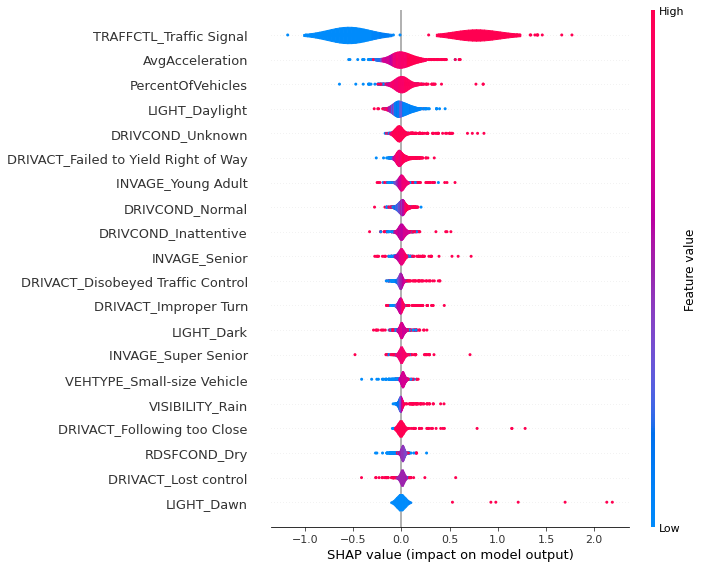

In [12]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X, plot_type = 'violin')